# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [131]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0

#### **1.2** Import necessary libraries

In [132]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [133]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [134]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [135]:

from google.colab import files
uploaded = files.upload()


Saving ingredient_and_quantity.json to ingredient_and_quantity (2).json


In [136]:
# define a function to load json file to a dataframe
file_path = "ingredient_and_quantity.json"
with open(file_path, 'r') as file:
    data = json.load(file)



##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [137]:
# read the json file by giving the file path and create a dataframe

df = pd.DataFrame(data)

##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [138]:
# display first five rows of the dataframe - df
df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2                                                                  1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice                                                                                       quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3  500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and  quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4                                                                                                                                                           1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry                                                                                                                                                                                                                                                                 qua

In [139]:
# print the dimensions of dataframe - df
df.shape

(285, 2)

In [140]:
# print the information of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [141]:
# split the input and pos into input_tokens and pos_tokens in the dataframe

# Tokenize input
df['input_tokens'] = df['input'].apply(lambda x: x.split())

# Tokenize POS
df['pos_tokens'] = df['pos'].apply(lambda x: x.split())

In [142]:
# display first five rows of the dataframe - df
df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                   input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]                                                                                                                                                        [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient                                                                                                [2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]                               

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [143]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

In [144]:
# check for the equality of input_length and pos_length in the dataframe
(df['input_length'] == df['pos_length']).all()


np.False_

##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [145]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it
def unique_labels(df):
    # Flatten the list of lists and extract unique labels using a set
    labels = set(label for sublist in df['pos_tokens'] for label in sublist)
    print("Unique POS labels in the dataset:")
    for label in sorted(labels):
        print(label)

##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

In [146]:
df.isnull().sum()

input           0
pos             0
input_tokens    0
pos_tokens      0
input_length    0
pos_length      0
dtype: int64

<font color = red>[write your answer]</font> <br>
There is no missed value


##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [147]:
# drop the irrelevant recipe data
def drop_irrelevant_recipe_data(df, irrelevant_labels):
    # Create a mask to filter out rows with irrelevant labels in the 'pos_tokens' column
    df_cleaned = df[~df['pos_tokens'].apply(lambda pos_list: any(label in irrelevant_labels for label in pos_list))]

    return df_cleaned
labels = unique_labels(df)

# Identify the irrelevant labels (for example, you might consider 'stopword' as irrelevant)
irrelevant_labels = {'stopword'}

# Drop rows with irrelevant data
df_cleaned = drop_irrelevant_recipe_data(df, irrelevant_labels)

# Show the cleaned DataFrame
print(df_cleaned)

Unique POS labels in the dataset:
ingredient
quantity
unit
                                                                                                                                                                                                                                                                                              input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                 

##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [148]:
# update the input and pos length in input_length and pos_length

def update_lengths(df):
    # Update 'input_length' based on the length of the 'input' text (number of characters)
    df['input_length'] = df['input'].apply(len)

    # Update 'pos_length' based on the length of the list in the 'pos_tokens' column
    df['pos_length'] = df['pos_tokens'].apply(len)

    return df


##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [149]:
# validate the input length and pos length as input_length and pos_length

def validate_lengths(df):
    # Validate input_length (should not be negative and should be a reasonable length)
    df['input_valid'] = df['input_length'].apply(lambda x: x > 0)  # Ensures input length is positive
    df['pos_valid'] = df.apply(lambda row: row['pos_length'] <= len(row['input'].split()) if row['input_length'] > 0 else False, axis=1)
    return df
df_updated = update_lengths(df)  # Add input_length and pos_length columns

# Validate the lengths
df_validated = validate_lengths(df_updated)

# Display the validated DataFrame
print(df_validated)


                                                                                                                                                                                                                                                                                              input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                            

## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [150]:
# split the dataset into training and validation sets

def split_data(df, test_size=0.3, random_state=42):
    # Split the dataset into training and validation sets (70:30 ratio)
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_state)

    return train_df, val_df

train_df, val_df = split_data(df, test_size=0.3, random_state=42)

# Display the training and validation datasets
print("Training Set:")
print(train_df)
print("\nValidation Set:")
print(val_df)


Training Set:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                input                                                                                                                                                                                                                                                                                                                                                                                                                                     

###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [151]:
# print the first five rows of train_df
train_df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         pos                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            pos_tokens  input_length  pos_length  input_valid  pos_valid
182                                                                                                                                                                                                                                                                                                            15 Gawar Phali Kothavarangai Cluster beans 1 inch Ginger 4 cloves Garlic 5 Green Chillies 3 tablespoons Roasted Peanuts Moongphali 1/4 teaspoon Coriander Dhania Seeds 1/2 Cumin seeds Jeera 18 grams Tamarind Salt Mustard White Urad Dal Split pinch Asafoetida hing                                                                                                                                                                                                                                                                                                                                                                                                                                                                              quantity ingredient ingredient ingredient ingredient ingredient quantity unit ingredient quantity unit ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient                                                         

In [152]:
# print the first five rows of the val_df
val_df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           pos                                                                                                                                                                                                                                                                                                                                                                                     input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        pos_tokens  input_length  pos_length  input_valid  pos_valid
9                                                                                                                                                                         1 cup cabbage leaves 3/4 tomatoes 18 grams tamarind 2 tablespoons white urad dal 4 red chillies 3 cloves garlic big Spoon oil teaspoon Rye 1/2 Cumin seeds sprig Curry                                                                                                                                                                                                                                                       quantity unit ingredient ingredient quantity ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient quantity ingredient ingredient ingredient unit ingredient unit ingredient quantity ingredient ingredient unit ingredient                                                                                                                                                                                            [1, cup, cabbage, leaves, 3/4, tomatoes, 18, grams, tamarind, 2, tablespoons, white, urad, dal, 4, red, chillies, 3, cloves, garlic, big, Spoon, oil, teaspoon, Rye, 1/2, Cumin, seeds, sprig, Curry]                                                                                                                                                                                                                                                                            [quantity, unit, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, unit, ingredient, unit, ingredient, quantity, ingredient, ingredient, unit, ingredient]           166          30         True       True
249                                                                                                                                                            12 Baby Potatoes 1 Dry Red Chilli teaspoon Cumin seeds sprig Curry leaves Coriander Powder 1/2 Turmeric powder Garam masala Amchur Mango Lemon juice 3 tablespoons Leaves chopped                                                                                                                                                                                                                                                   

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [153]:
# extract the training and validation sets by taking input_tokens and pos_tokens
train_set = train_df[['input', 'pos_tokens']]
val_set = val_df[['input', 'pos_tokens']]


In [154]:
# validate the shape of training and validation samples
train_shape = train_set.shape
val_shape = val_set.shape

# Print the shape of the training and validation sets
print(f"Training Set Shape: {train_shape}")
print(f"Validation Set Shape: {val_shape}")

Training Set Shape: (199, 2)
Validation Set Shape: (86, 2)


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [155]:
# Display the number of unique labels present in y_train
y_train = train_set['pos_tokens']

# Flatten the list of lists and extract unique labels using a set
unique_labels = set(label for sublist in y_train for label in sublist)

# Display the number of unique labels
print(f"Number of unique labels in y_train: {len(unique_labels)}")
print(f"Unique labels: {sorted(unique_labels)}")


Number of unique labels in y_train: 3
Unique labels: ['ingredient', 'quantity', 'unit']


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [156]:
# flatten the list for nested_list (input_tokens, pos_tokens)
dataset_name = 'Training'

input_tokens = df['input_tokens'].tolist()
pos_tokens = df['pos_tokens'].tolist()

# Flatten the nested lists
flattened_input_tokens = [token for sublist in input_tokens for token in sublist]
flattened_pos_tokens = [token for sublist in pos_tokens for token in sublist]

# Print results
print(f"Dataset Name: {dataset_name}")
print("Flattened input_tokens:", flattened_input_tokens)
print("Flattened pos_tokens:", flattened_pos_tokens)


Dataset Name: Training
Flattened input_tokens: ['6', 'Karela', 'Bitter', 'Gourd', 'Pavakkai', 'Salt', '1', 'Onion', '3', 'tablespoon', 'Gram', 'flour', 'besan', '2', 'teaspoons', 'Turmeric', 'powder', 'Haldi', 'Red', 'Chilli', 'Cumin', 'seeds', 'Jeera', 'Coriander', 'Powder', 'Dhania', 'Amchur', 'Dry', 'Mango', 'Sunflower', 'Oil', '2-1/2', 'cups', 'rice', 'cooked', '3', 'tomatoes', 'teaspoons', 'BC', 'Belle', 'Bhat', 'powder', '1', 'teaspoon', 'chickpea', 'lentils', '1/2', 'cumin', 'seeds', 'white', 'urad', 'dal', 'mustard', 'green', 'chilli', 'dry', 'red', '2', 'cashew', 'or', 'peanuts', '1-1/2', 'tablespoon', 'oil', 'asafoetida', '1-1/2', 'cups', 'Rice', 'Vermicelli', 'Noodles', 'Thin', '1', 'Onion', 'sliced', '1/2', 'cup', 'Carrots', 'Gajjar', 'chopped', '1/3', 'Green', 'peas', 'Matar', '2', 'Chillies', '1/4', 'teaspoon', 'Asafoetida', 'hing', 'Mustard', 'seeds', 'White', 'Urad', 'Dal', 'Split', 'Ghee', 'sprig', 'Curry', 'leaves', 'Salt', 'Lemon', 'juice', '500', 'grams', 'Chicken',

In [157]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [158]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens
def extract_and_validate_tokens(df, dataset_name):
  input_tokens_flat = []
  for index in df.index:
        input_tokens_flat.extend(df.loc[index, 'input_tokens'])

  pos_tokens_flat = []
  for index in df.index:
        pos_tokens_flat.extend(df.loc[index, 'pos_tokens'])
  assert len(input_tokens_flat) == len(pos_tokens_flat)

In [159]:
# extract the tokens and its pos tags
input_tokens = df['input_tokens'].tolist()
pos_tokens = df['pos_tokens'].tolist()

# Flatten the nested lists
token_pos_pairs = list(zip(flattened_input_tokens, flattened_pos_tokens))

# Print the extracted token-POS pairs
print("Token-POS pairs:")
for token, pos in token_pos_pairs:
    print(f"{token} → {pos}")

Streaming output truncated to the last 5000 lines.
oil → ingredient
1 → ingredient
teaspoon → unit
cumin → ingredient
seeds → ingredient
cloves → ingredient
garlic → ingredient
grated → ingredient
onions → ingredient
finely → ingredient
chopped → ingredient
red → quantity
chilli → ingredient
powder → unit
1/2 → ingredient
turmeric → ingredient
cup → ingredient
coconut → ingredient
milk → unit
vegetable → ingredient
Stock → ingredient
tablespoons → ingredient
Dijon → ingredient
Mustard → ingredient
carrots → ingredient
cut → quantity
round → ingredient
thinly → ingredient
5 → ingredient
green → ingredient
beans → ingredient
into → quantity
small → ingredient
pieces → ingredient
1/4 → ingredient
peas → ingredient
steam → ingredient
potatoes → quantity
boiled → unit
salt → ingredient
1 → ingredient
cup → quantity
Basmati → unit
rice → ingredient
120 → ingredient
ml → unit
Coconut → ingredient
milk → ingredient
teaspoon → quantity
Turmeric → ingredient
powder → ingredient
10 → ingredient
G

#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [160]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays

def categorize_tokens(tokens, pos_tags):
    """
    Categorize tokens into ingredient, unit, and quantity lists based on POS tags.
    Only valid labels are allowed. Otherwise, return empty lists.

    Parameters:
        tokens (list): List of tokens (words).
        pos_tags (list): Corresponding list of POS tags.

    Returns:
        tuple: ingredient_list, unit_list, quantity_list
    """
    # Allowed POS labels
    valid_labels = {'ingredient', 'unit', 'quantity'}

    # Validate that all pos_tags are among the valid ones
    if not all(tag in valid_labels for tag in pos_tags):
        return [], [], []

    # Initialize categorized lists
    ingredient_list = []
    unit_list = []
    quantity_list = []

    # Categorize tokens
    for token, tag in zip(tokens, pos_tags):
        if tag == 'ingredient':
            ingredient_list.append(token)
        elif tag == 'unit':
            unit_list.append(token)
        elif tag == 'quantity':
            quantity_list.append(token)

    return ingredient_list, unit_list, quantity_list


In [161]:
#  call the function to categorise the labels into respective list
#  call the function to categorise the labels into respective list
ingredients, units, quantities = categorize_tokens(flattened_input_tokens, flattened_pos_tokens) # Pass the flattened lists as arguments

# Print the results
print("Ingredients:", ingredients)
print("Units:", units)
print("Quantities:", quantities)

Ingredients: ['Karela', 'Bitter', 'Gourd', 'Pavakkai', 'Salt', 'Onion', 'Gram', 'flour', 'besan', 'Turmeric', 'powder', 'Haldi', 'Red', 'Chilli', 'Cumin', 'seeds', 'Jeera', 'Coriander', 'Powder', 'Dhania', 'Amchur', 'Dry', 'Mango', 'Sunflower', 'Oil', 'rice', 'cooked', 'tomatoes', 'BC', 'Belle', 'Bhat', 'powder', 'chickpea', 'lentils', 'cumin', 'seeds', 'white', 'urad', 'dal', 'mustard', 'green', 'chilli', 'dry', 'red', 'cashew', 'or', 'peanuts', 'oil', 'asafoetida', 'Rice', 'Vermicelli', 'Noodles', 'Thin', 'Onion', 'sliced', 'Carrots', 'Gajjar', 'chopped', 'Green', 'peas', 'Matar', 'Chillies', 'Asafoetida', 'hing', 'Mustard', 'seeds', 'White', 'Urad', 'Dal', 'Split', 'Ghee', 'Curry', 'leaves', 'Salt', 'Lemon', 'juice', 'Chicken', 'Onion', 'chopped', 'Tomato', 'Green', 'Chillies', 'slit', 'Ginger', 'finely', 'Garlic', 'Turmeric', 'powder', 'Haldi', 'Garam', 'masala', 'Sesame', 'Gingelly', 'Oil', 'Methi', 'Seeds', 'Fenugreek', 'Coriander', 'Dhania', 'Dry', 'Red', 'Fennel', 'seeds', 'Sau

#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [162]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items
def get_top_frequent_items(item_list, pos_label, dataset_name):
    """
    Get the top 10 most frequent items in a list.

    Parameters:
        item_list (list): List of items (e.g., ingredients, units).
        pos_label (str): Label for the item type (e.g., 'ingredient', 'unit').
        dataset_name (str): Name of the dataset (e.g., 'Training', 'Validation').

    Returns:
        list: Top 10 most frequent items.
    """
    # Count item frequencies
    item_counts = Counter(item_list)

    # Get top 10 most frequent items
    top_items = item_counts.most_common(10)

    print(f"Top 10 most frequent {pos_label}s in {dataset_name} data:")
    for item, count in top_items:
        print(f"{item}: {count}")

    return top_items

In [163]:
# get the top ingredients which are frequently seen in the recipe
top_ingredients = get_top_frequent_items(ingredients, 'ingredient', dataset_name)

Top 10 most frequent ingredients in Training data:
1: 200
teaspoon: 172
2: 159
1/2: 154
powder: 149
cup: 142
Salt: 116
seeds: 109
1/4: 104
Red: 97


In [164]:
# get the top units which are frequently seen in the recipe
top_units = get_top_frequent_items(units, 'unit', dataset_name)

Top 10 most frequent units in Training data:
1: 28
teaspoon: 27
cup: 27
2: 26
tablespoon: 24
1/2: 24
Onion: 21
Oil: 18
powder: 18
Salt: 17


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [165]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name
import matplotlib.pyplot as plt
import seaborn as sns

def plot_top_items(top_items, pos_label, dataset_name):
    """
    Plots a bar graph of the top 10 most frequent items.

    Parameters:
        top_items (list): List of tuples containing items and their frequencies.
        pos_label (str): Label for the item type (e.g., 'ingredient', 'unit').
        dataset_name (str): Name of the dataset (e.g., 'Training', 'Validation').
    """
    items, counts = zip(*top_items)  # Unpack items and counts from tuples

    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    sns.barplot(x=counts, y=items, orient='h')  # Create horizontal bar plot

    plt.title(f"Top 10 Most Frequent {pos_label}s in {dataset_name} Data")
    plt.xlabel("Frequency")
    plt.ylabel(f"{pos_label}")

    plt.show()  # Display the plot

#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



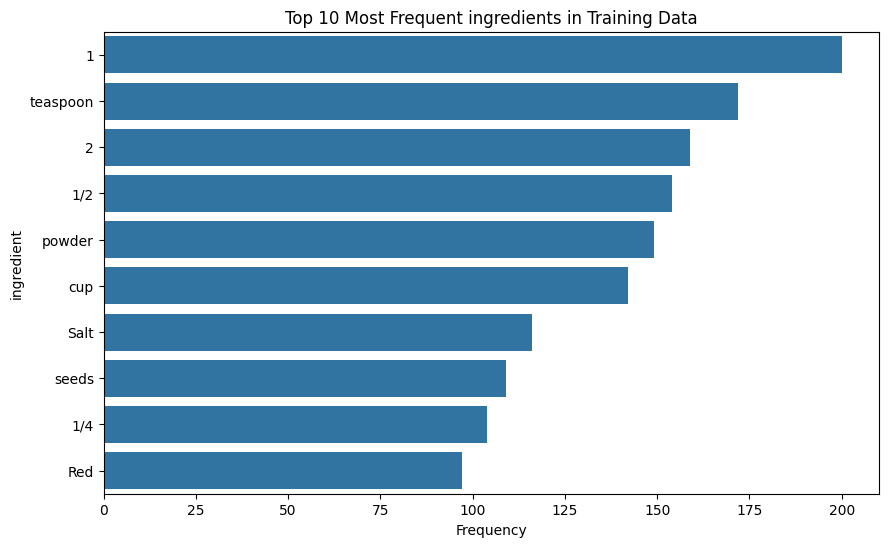

In [166]:
# plot the top frequent ingredients in training data
# plot the top frequent ingredients in training data
plot_top_items(top_ingredients, 'ingredient', dataset_name)

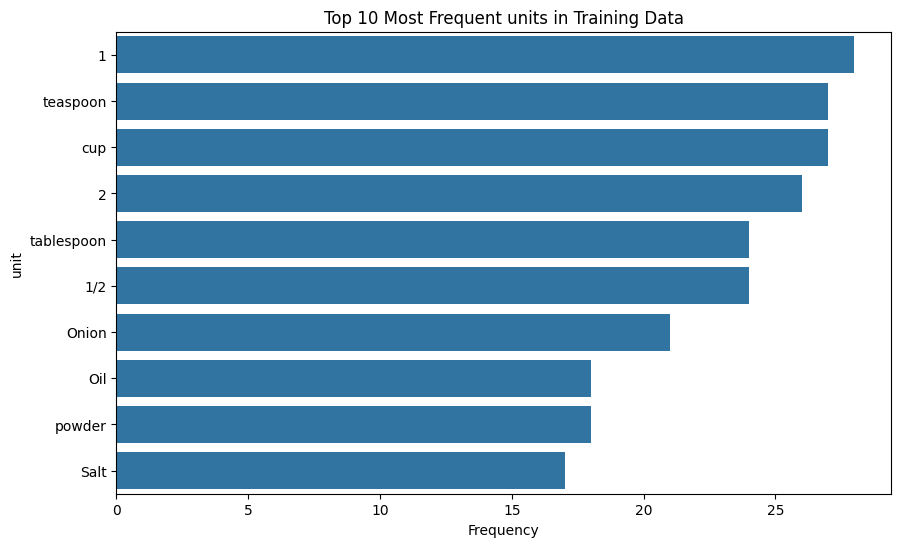

In [167]:
# plot the top frequent units in training data

plot_top_items(top_units, 'unit', dataset_name)

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [168]:
# initialise the dataset_name
dataset_name = 'Training'


In [169]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe
def extract_and_validate_tokens(df, dataset_name):
  input_tokens_flat = []
  for index in df.index:
        input_tokens_flat.extend(df.loc[index, 'input_tokens'])

  pos_tokens_flat = []
  for index in df.index:
        pos_tokens_flat.extend(df.loc[index, 'pos_tokens'])

# 1. Extract and validate tokens (from val_df)
dataset_name = 'Validation'
extract_and_validate_tokens(val_df, dataset_name)

# Assuming extract_and_validate_tokens updates global variables
# for flattened_input_tokens and flattened_pos_tokens

# 2. Categorize tokens
val_ingredients, val_units, val_quantities = categorize_tokens(flattened_input_tokens, flattened_pos_tokens)

# 3. Get top frequent items for ingredients
top_val_ingredients = get_top_frequent_items(val_ingredients, 'ingredient', dataset_name)

# 4. Get top frequent items for units
top_val_units = get_top_frequent_items(val_units, 'unit', dataset_name)

Top 10 most frequent ingredients in Validation data:
1: 200
teaspoon: 172
2: 159
1/2: 154
powder: 149
cup: 142
Salt: 116
seeds: 109
1/4: 104
Red: 97
Top 10 most frequent units in Validation data:
1: 28
teaspoon: 27
cup: 27
2: 26
tablespoon: 24
1/2: 24
Onion: 21
Oil: 18
powder: 18
Salt: 17


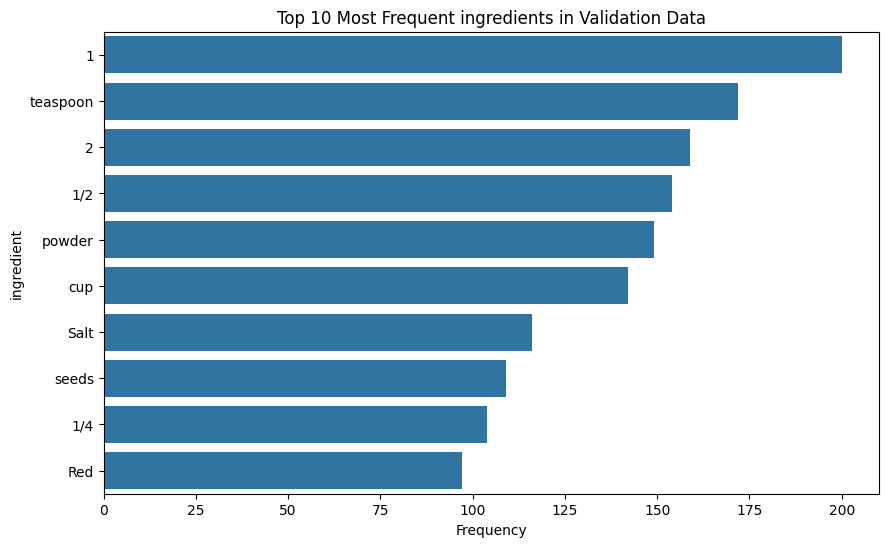

In [170]:
# plot the top frequent ingredients in validation data

plot_top_items(top_val_ingredients, 'ingredient', dataset_name)

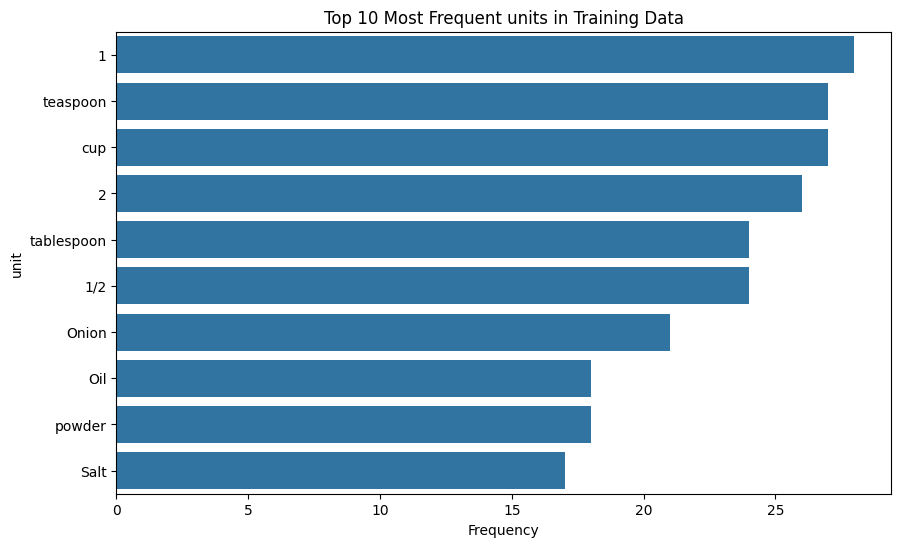

In [171]:
# plot the top frequent units in training data
plot_top_items(top_units, 'unit', 'Training')

## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [172]:
# define unit and quantity keywords along with quantity pattern
import re

# Define unit keywords
unit_keywords = {
    "cup", "cups", "teaspoon", "teaspoons", "tablespoon", "tablespoons",
    "tbsp", "tsp", "gram", "grams", "g", "kg", "kilogram", "kilograms",
    "ml", "milliliter", "milliliters", "liter", "liters", "l", "ounce",
    "ounces", "oz", "pound", "pounds", "lb", "pinch", "pinches", "dash",
    "dashes"  # Add more as needed
}

# Define quantity keywords
quantity_keywords = {
    "half", "quarter", "a", "an", "one", "two", "three", "four", "five",
    "six", "seven", "eight", "nine", "ten",  # Add more as needed
}

# Define quantity pattern using regular expression
quantity_pattern = re.compile(r"(\d+\s*\d*/\d+|\d+/\d+|\d+\.\d+|\d+)")
# Matches fractions (e.g., 1 1/2, 1/2), decimals (e.g., 3.14), and whole numbers (e.g., 2)

# Load spaCy model (assuming you want to use it for feature extraction)
import spacy
nlp = spacy.load("en_core_web_sm")  # Choose the appropriate model

In [173]:
# load spaCy model
import spacy

nlp = spacy.load("en_core_web_sm")  # Load a spaCy model (e.g., 'en_core_web_sm')

##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [174]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions

    # Process the entire sentence with spaCy

    # --- Core Features ---

    # --- Improved Quantity & Unit Detection ---

    # --- Contextual Features ---
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'token': word.lower(),
        'lemma': nlp(word)[0].lemma_.lower(),  # Use spaCy for lemmatization
        'pos_tag': postag,
        'tag': postag,  # Detailed POS tag (same as pos_tag here)
        'dep': nlp(word)[0].dep_,  # Use spaCy for dependency parsing
        'shape': word.lower(),  # Basic shape for now
        'is_stop': nlp.vocab[word.lower()].is_stop,
        'is_digit': word.isdigit(),
        'has_digit': any(char.isdigit() for char in word),
        'has_alpha': any(char.isalpha() for char in word),
        'hyphenated': '-' in word,
        'slash_present': '/' in word,
        'is_title': word.istitle(),
        'is_upper': word.isupper(),
        'is_punct': word.islower(),  # Check if it's a punctuation mark

        'is_quantity': word.lower() in quantity_keywords or quantity_pattern.match(word),
        'is_unit': word.lower() in unit_keywords,
        'is_numeric': word.lower() in quantity_keywords or quantity_pattern.match(word),  # Similar to is_quantity
        'is_fraction': bool(re.search(r'\d+/\d+', word)),  # Check for fractions
        'is_decimal': bool(re.search(r'\d+\.\d+', word)),  # Check for decimals
        'preceding_word': '' if i == 0 else sent[i - 1][0].lower(),
        'following_word': '' if i == len(sent) - 1 else sent[i + 1][0].lower(),

        'prev_token': '' if i == 0 else sent[i-1][0].lower(),
        'prev_is_quantity': (i > 0 and sent[i-1][0].lower() in quantity_keywords or quantity_pattern.match(sent[i-1][0]) if i > 0 else False),
        'prev_is_digit': (i > 0 and sent[i-1][0].isdigit() if i > 0 else False),
        'BOS': i == 0,
        'next_token': '' if i == len(sent)-1 else sent[i+1][0].lower(),
        'next_is_unit': (i < len(sent)-1 and sent[i+1][0].lower() in unit_keywords if i < len(sent)-1 else False),
        'next_is_ingredient': (i < len(sent)-1 and sent[i+1][0].lower() not in unit_keywords and sent[i+1][0].lower() not in quantity_keywords if i < len(sent)-1 else False),
        'EOS': i == len(sent)-1
    }
    return features

### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [175]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [176]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features
X_train_features = [sent2features(sent) for sent in train_df[['input_tokens', 'pos_tokens']].values.tolist()]
X_val_features = [sent2features(sent) for sent in val_df[['input_tokens', 'pos_tokens']].values.tolist()]

##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [177]:
# Convert labels into list as y_train_labels and y_val_labels
y_train_labels = train_df['pos_tokens'].tolist()
y_val_labels = val_df['pos_tokens'].tolist()

##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [178]:
# print the length of train features and labels
print(len(X_train_features))
print(len(y_train_labels))

199
199


In [179]:
# print the length of validation features and labels
print(len(X_val_features))
print(len(y_val_labels))

86
86


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [180]:
# Flatten labels in y_train
y_train_flat = [label for sublist in y_train_labels for label in sublist]

##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [181]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts
from collections import Counter

label_counts = Counter(y_train_flat)
total_samples = sum(label_counts.values())

##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [182]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts
weight_dict = {label: total_samples / (label_counts[label] * len(label_counts))
               for label in label_counts}

In [183]:
# penalise ingredient label
weight_dict['ingredient'] *= 0.5  # Reduce the weight of 'ingredient' by half

##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [184]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)
def extract_features_with_class_weights(X, y, weight_dict):
    """
    Applies class weights to feature extraction.

    Args:
        X: Input tokens (list of lists of tokens).
        y: Labels (list of lists of labels).
        weight_dict: Dictionary containing class weights.

    Returns:
        X_weighted: Feature sets with weights applied.
    """

    X_weighted = []
    for sent_features, sent_labels in zip(X, y):
        sent_weighted_features = []
        for features, label in zip(sent_features, sent_labels):
            features['weight'] = weight_dict.get(label, 1.0)  # Apply weight or default to 1.0
            sent_weighted_features.append(features)
        X_weighted.append(sent_weighted_features)

    return X_weighted

##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [185]:
# Apply manually computed class weights
X_train_weighted_features = extract_features_with_class_weights(X_train_features, y_train_labels, weight_dict)
X_val_weighted_features = extract_features_with_class_weights(X_val_features, y_val_labels, weight_dict)

## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [206]:
# initialise CRF model with the specified hyperparameters and use weight_dict

# train the CRF model with the weighted training data
import re
import spacy
from sklearn_crfsuite import CRF

nlp = spacy.load("en_core_web_sm")  # Make sure model is loaded

def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    doc = nlp(word)

    features = {
        'bias': 1.0,
        'token': word.lower(),
        'lemma': doc[0].lemma_.lower() if doc else word.lower(),
        'pos_tag': postag,
        'tag': postag,
        'dep': doc[0].dep_ if doc else 'NA',
        'shape': word.lower(),
        'is_stop': nlp.vocab[word.lower()].is_stop,
        'is_digit': word.isdigit(),
        'has_digit': any(char.isdigit() for char in word),
        'has_alpha': any(char.isalpha() for char in word),
        'hyphenated': '-' in word,
        'slash_present': '/' in word,
        'is_title': word.istitle(),
        'is_upper': word.isupper(),
        'is_punct': word.islower(),

        'is_quantity': bool(quantity_pattern.match(word)),
        'is_unit': word.lower() in unit_keywords,
        'is_numeric': bool(quantity_pattern.match(word)),
        'is_fraction': bool(re.search(r'\d+/\d+', word)),
        'is_decimal': bool(re.search(r'\d+\.\d+', word)),

        'preceding_word': '' if i == 0 else sent[i - 1][0].lower(),
        'following_word': '' if i == len(sent) - 1 else sent[i + 1][0].lower(),

        'prev_token': '' if i == 0 else sent[i - 1][0].lower(),
        'prev_is_quantity': bool(i > 0 and (sent[i - 1][0].lower() in quantity_keywords or quantity_pattern.match(sent[i - 1][0]))),
        'prev_is_digit': bool(i > 0 and sent[i - 1][0].isdigit()),
        'BOS': i == 0,
        'next_token': '' if i == len(sent) - 1 else sent[i + 1][0].lower(),
        'next_is_unit': bool(i < len(sent) - 1 and sent[i + 1][0].lower() in unit_keywords),
        'next_is_ingredient': bool(i < len(sent) - 1 and sent[i + 1][0].lower() not in unit_keywords and sent[i + 1][0].lower() not in quantity_keywords),
        'EOS': i == len(sent) - 1
    }

    return features
train_sents = [list(zip(tokens, pos)) for tokens, pos in zip(train_df['input_tokens'], train_df['pos_tokens'])]
X_train_weighted_features = [[word2features(sent, i) for i in range(len(sent))] for sent in train_sents]
crf = CRF(
    algorithm='lbfgs',
    c1=0.5,
    c2=1.0,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train_weighted_features, y_train_labels)


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.5, c2=1.0,
    max_iterations=100)

### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [207]:
# evaluate on the training dataset
y_train_pred = crf.predict(X_train_weighted_features)

In [208]:
# specify the flat classification report by using training data for evaluation
from sklearn_crfsuite.metrics import flat_classification_report

# Assuming 'crf' is your trained CRF model
# and 'X_train_weighted_features' and 'y_train_labels' are your training data

# Predict labels for the training data
y_train_pred = crf.predict(X_train_weighted_features)

# Generate and print the classification report
report = flat_classification_report(y_train_labels, y_train_pred)
print(report)

              precision    recall  f1-score   support

  ingredient       1.00      1.00      1.00      5251
    quantity       1.00      1.00      1.00       989
        unit       1.00      1.00      1.00       833

    accuracy                           1.00      7073
   macro avg       1.00      1.00      1.00      7073
weighted avg       1.00      1.00      1.00      7073



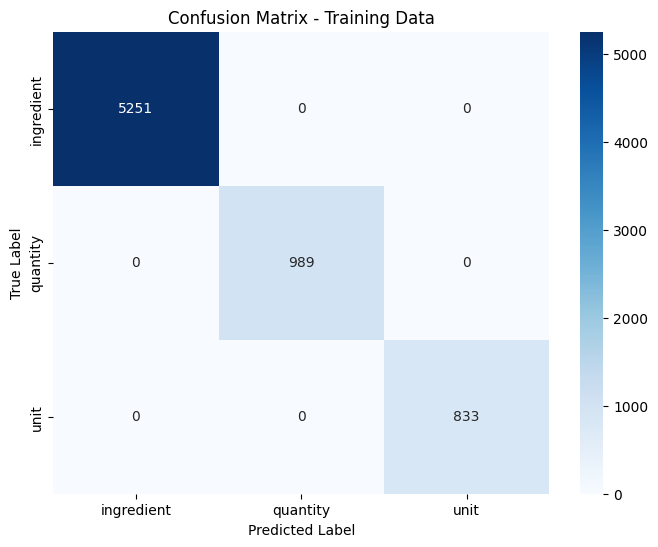

In [209]:
# create a confusion matrix on training datset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Assuming 'crf' is your trained CRF model
# and 'X_train_weighted_features' and 'y_train_labels' are your training data

# Predict labels for the training data
y_train_pred = crf.predict(X_train_weighted_features)

# Flatten the predicted and true labels
y_train_pred_flat = [label for sublist in y_train_pred for label in sublist]
y_train_labels_flat = [label for sublist in y_train_labels for label in sublist]

# Get unique labels
labels = unique_labels(y_train_labels_flat, y_train_pred_flat)

# Create confusion matrix
cm = confusion_matrix(y_train_labels_flat, y_train_pred_flat, labels=labels)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Training Data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [210]:
# dump the model using joblib as crf_model.pkl
import joblib

# Save the model to a file
joblib.dump(crf, 'crf_model.pkl')


['crf_model.pkl']

## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [214]:
# predict the crf model on validation dataset

# Precompute the spaCy docs
# Precompute the spaCy docs, processing each token list as a string
docs_val = list(nlp.pipe(val_df['input_tokens'].apply(' '.join)))


In [217]:
# specify flat classification report
from sklearn_crfsuite.metrics import flat_classification_report

y_pred = crf.predict(X_val_weighted_features)
# Flatten the predicted

y_pred_flat = [label for sublist in y_pred for label in sublist]

# Generate and print the flat classification report
report = flat_classification_report(y_val_labels, y_pred, labels=list(crf.classes_))
print(report)

SystemError: <cyfunction Tagger.tag at 0x7ba89d940040> returned a result with an exception set

In [219]:
# create a confusion matrix on validation dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np


y_pred = crf.predict(X_val_weighted_features)

# Flatten the true and predicted labels
y_val_flat = [label for sublist in y_val_labels for label in sublist]
y_pred_flat = [label for sublist in y_pred for label in sublist]

# Create the confusion matrix
cm = confusion_matrix(y_val_flat, y_pred_flat, labels=list(crf.classes_))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(crf.classes_),
            yticklabels=list(crf.classes_))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for CRF Model on Validation Data")
plt.show()

SystemError: <cyfunction Tagger.tag at 0x7ba89d940040> returned a result with an exception set

## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [222]:

# flatten Labels and Initialise Error Data
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

y_val_flat = [label for sublist in y_val_labels for label in sublist]
y_pred = crf.predict(X_val_weighted_features)  # Make predictions first
y_pred_flat = [label for sublist in y_pred for label in sublist] # Now y_pred is defined

SystemError: <cyfunction Tagger.tag at 0x7ba89d940040> returned a result with an exception set

##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [223]:
# iterate and collect Error Information

            # get previous and next tokens with handling for boundary cases
error_data = []
for i, (tokens, true_labels, predicted_labels) in enumerate(zip(X_val_weighted_features, y_val_labels, y_pred)):
    for j, (token, true_label, predicted_label) in enumerate(zip(tokens, true_labels, predicted_labels)):
        if true_label != predicted_label:
            # Collect error information
            error_info = {
                'sentence_index': i,
                'token_index': j,
                'token': token.get('token'), # get the original token
                'true_label': true_label,
                'predicted_label': predicted_label,
                'preceding_word': token.get('prev_token'),
                'following_word': token.get('next_token'),
                'class_weight': token.get('weight', 1.0)
            }
            error_data.append(error_info)

NameError: name 'y_pred' is not defined

##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [ ]:
# Create DataFrame and Print Overall Accuracy
import pandas as pd
from sklearn.metrics import accuracy_score

# Create DataFrame
error_df = pd.DataFrame(error_data)

# Calculate Overall Accuracy
overall_accuracy = accuracy_score(y_val_flat, y_pred_flat)

# Print Overall Accuracy
print(f"Overall Accuracy: {overall_accuracy:.2f}")

# Display Error DataFrame (optional)
display(error_df)

##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [ ]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context

label_errors = error_df.groupby('true_label')

for label, group in label_errors:
    accuracy = 1 - (len(group) / label_counts[label])  # Accuracy for this label
    class_weight = weight_dict[label]  # Get class weight

    print(f"Analysis for label: {label}")
    print(f"  - Accuracy: {accuracy:.2f}")
    print(f"  - Class Weight: {class_weight:.2f}")
    print(f"  - Number of Errors: {len(group)}")

    # Display error details for this label
    display(group[['token', 'preceding_word', 'following_word', 'true_label', 'predicted_label']])
    print("\n")


### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




 <font color = red>[Write your answer]</font>

## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.